# CS4035 - Cyber Data Analytics
## Lab 3 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 3 contains 4 main questions + 1 bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 42

## Student 1 
### Name : Otte van Dam
### ID : 5096790

## Student 2
### Name : Suhaib Basir
### ID : 5059151

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [3]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nbformat
from tqdm import tqdm

nb = nbformat.read("Lab3.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 326


## 1. Familiarization and discretization task – 1 A4 (5 Points)

In [4]:
# Specify the columns you want to read as strings
string_columns = ['sTos', 'dTos']

data = "dataset_lab3/dataset_10/capture20110818.binetflow"
df = pd.read_csv(data)
df1 = pd.read_csv(data, dtype={col: str for col in string_columns})
print(df1['sTos'].unique())
print(df1.iloc[0:5])
# display(type(df1['sTos'][0]))

['0' '192' nan '3' '2' '1']
                    StartTime         Dur Proto         SrcAddr  Sport    Dir  \
0  2011/08/18 10:21:46.633335    1.060248   tcp    93.45.239.29   1611     ->   
1  2011/08/18 10:19:49.027650  279.349152   tcp  62.240.166.118   1031    <?>   
2  2011/08/18 10:22:07.160628  166.390015   tcp   147.32.86.148  58067     ->   
3  2011/08/18 10:26:02.052163    1.187083   tcp     147.32.3.51   3130     ->   
4  2011/08/18 10:26:52.226748    0.980571   tcp   88.212.37.169   3134     ->   

          DstAddr  Dport    State sTos dTos  TotPkts  TotBytes  SrcBytes  \
0   147.32.84.118   6881     S_RA    0    0        4       252       132   
1   147.32.84.229  13363  SRPA_PA    0    0       15      1318       955   
2  66.235.132.232     80    SR_SA    0    0        3       212       134   
3    147.32.84.46  10010     S_RA    0    0        4       244       124   
4   147.32.84.118   6881     S_RA    0    0        4       244       124   

                            

In [9]:
# Use the value_counts() function to count the occurrences of each value in the 'SrcAddr' column
srcaddr_counts = df1['SrcAddr'].value_counts()

# Get the most occurring value by accessing the first element of the resulting series
most_common_value = srcaddr_counts.index[0]

# Print the most occurring value
print("Most occurring value in 'SrcAddr':", most_common_value, ' with ', srcaddr_counts[0], ' occurences, out of ', len(df1), ' occurences in total')

# Discretize numeric columns using percentiles
for column in df1.columns:
    if df1[column].dtype == np.float64 or df1[column].dtype == np.int64:
        df1[column] = pd.qcut(df1[column], q=10, labels=False, duplicates='drop')

Most occurring value in 'SrcAddr': 147.32.84.138  with  211967  occurences, out of  1309791  occurences in total


### 1a. Plot visualizations - Select and visualize two features for modeling the behavior of the infected host.

In [10]:
# Filter columns that are either integers or floats
numeric_cols_147 = df1[df1['SrcAddr'] == '147.32.84.138'].select_dtypes(include=['int', 'float'])
numeric_cols_other = df1[df1['SrcAddr'] != '147.32.84.138'].select_dtypes(include=['int', 'float'])

# Calculate the average and standard deviation for df_srcaddr_147
avg_values_147 = numeric_cols_147.mean()
std_values_147 = numeric_cols_147.std()
print(f'calculated for 147')

# Calculate the average and standard deviation for df_srcaddr_other
avg_values_other = numeric_cols_other.mean()
std_values_other = numeric_cols_other.std()
print('calculated for other')

# Print the average and standard deviation side by side
print(f"{'Column':<15} {'Average (147)':<15} {'Std Deviation (147)':<20} {'Average (Other)':<15} {'Std Deviation (Other)':<20}")
print("-" * 90)
for column in avg_values_147.index:
    avg_147 = avg_values_147[column]
    std_147 = std_values_147[column]
    avg_other = avg_values_other[column]
    std_other = std_values_other[column]
    print(f"{column:<15} {avg_147:<15.2f} {std_147:<20.2f} {avg_other:<15.2f} {std_other:<20.2f}")

calculated for 147
calculated for other
Column          Average (147)   Std Deviation (147)  Average (Other) Std Deviation (Other)
------------------------------------------------------------------------------------------
Dur             0.95            0.90                 4.11            2.67                
TotPkts         0.00            0.05                 0.68            1.06                
TotBytes        0.01            0.17                 3.22            2.39                
SrcBytes        1.00            0.11                 3.13            2.46                


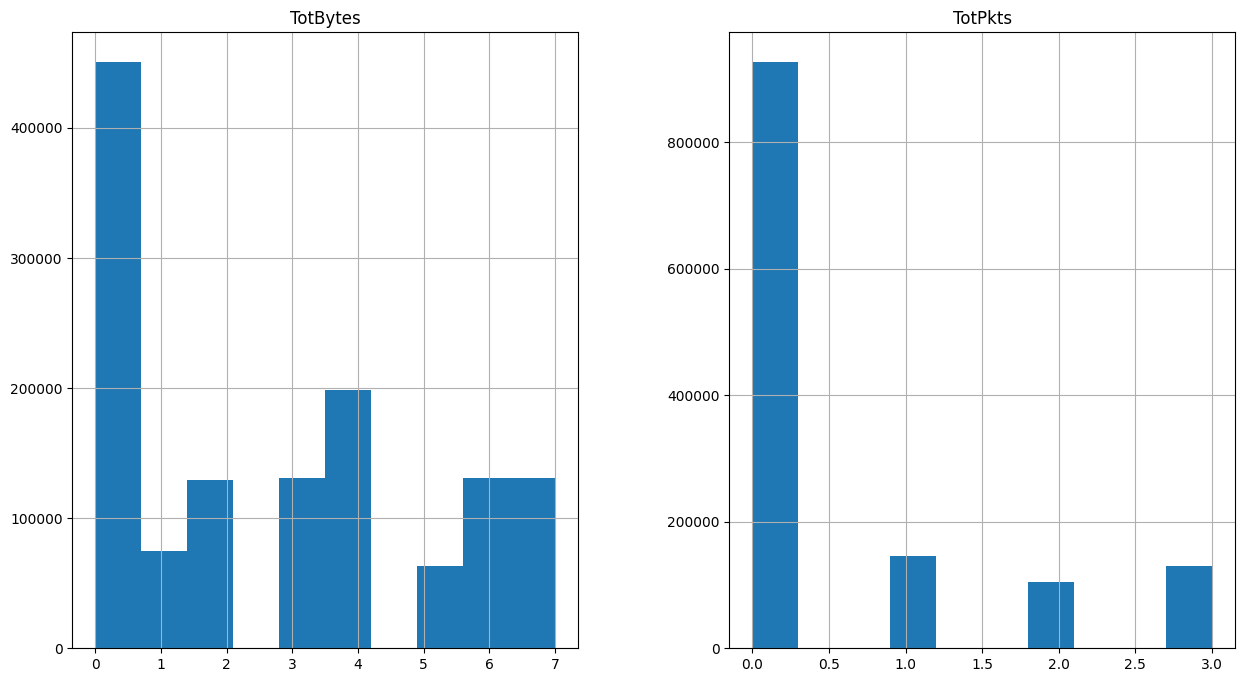

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Let's start by visualizing the 'TotBytes' and 'TotPkts' features
df1[['TotBytes', 'TotPkts']].hist(bins=10, figsize=(15, 8))
plt.show()

# Combine the two discretized features into a single feature
df1['combined_feature'] = df1['TotBytes'].astype(str) + '_' + df1['TotPkts'].astype(str)

### 1b. Discretize selected features

### 1c. Answers and explanation

## 2. Sketching task – 1/2 A4 (Individual, 10 Points)

### 2a. COUNT-MIN sketch


### 2b. Analysis and answers to the questions

## 3. Min-wise locality sensitive hashing task – 1/2 A4 (Individual, 10 Points)

### 3a. Implementation

### 3b. Analysis and answers to the questions

## 4.Botnet profiling and fingerprinting task – 1 A4 (5 Points)

### 4a. Learn a sequential model, profiling and fingerprinting

### 4b. Analysis and answers to the questions.

## 5. Bonus Task 1/2 A4 (5 Points)

### 5a. Provide implementation and analysis.